In [7]:
import matplotlib.pyplot as plt 
import pandas as pd 
import numpy as np 
import seaborn as sns
import scipy.stats 
import plotly.express as px
import sys
import os
import dotenv

In [8]:
current_dir = os.getcwd()
project_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
src_path = os.path.join(project_dir, 'src')
sys.path.append(src_path)

from utils import load_env_vars
load_env_vars()

In [9]:
healthy_lifestyle_csv = os.getenv("healthy_lifestyle_csv")

## What The Dataset Looks Like

In [10]:
df = pd.read_csv(healthy_lifestyle_csv)
print(df.shape)
df.head()   

ValueError: Invalid file path or buffer object type: <class 'NoneType'>

## Changing Messy Column Names

In [ ]:
df.columns = ["city", "rank", "sunshine_hours", "bottled_water_cost", "obesity_percent", "life_expectancy", "pollution_index", "avg_hours_worked", "happiness_levels", "outdoor_activities", "takeout_places", "gym_cost"]
df.head()

,city,rank,sunshine_hours,bottled_water_cost,obesity_percent,life_expectancy,pollution_index,avg_hours_worked,happiness_levels,outdoor_activities,takeout_places,gym_cost
0,Amsterdam,1,1858,£1.92,20.40%,81.2,30.93,1434,7.44,422,1048,£34.90
1,Sydney,2,2636,£1.48,29.00%,82.1,26.86,1712,7.22,406,1103,£41.66
2,Vienna,3,1884,£1.94,20.10%,81.0,17.33,1501,7.29,132,1008,£25.74
3,Stockholm,4,1821,£1.72,20.60%,81.8,19.63,1452,7.35,129,598,£37.31
4,Copenhagen,5,1630,£2.19,19.70%,79.8,21.24,1380,7.64,154,523,£32.53


## Checking Data Types

In [ ]:
df.dtypes

city                   object
rank                    int64
sunshine_hours         object
bottled_water_cost     object
obesity_percent        object
life_expectancy       float64
pollution_index        object
avg_hours_worked       object
happiness_levels      float64
outdoor_activities      int64
takeout_places          int64
gym_cost               object
dtype: object

## Checking For Missing Data

In this dataset, missing values are represented by "-" so I will replace them with NaN

In [ ]:
df.replace("-", np.nan, inplace=True)

In [ ]:
df_missing_values = df.isnull()
for column in df_missing_values.columns.values.tolist():
    print(df_missing_values[column].value_counts())
    print()

city
False    44
Name: count, dtype: int64

rank
False    44
Name: count, dtype: int64

sunshine_hours
False    43
True      1
Name: count, dtype: int64

bottled_water_cost
False    44
Name: count, dtype: int64

obesity_percent
False    44
Name: count, dtype: int64

life_expectancy
False    44
Name: count, dtype: int64

pollution_index
False    43
True      1
Name: count, dtype: int64

avg_hours_worked
False    33
True     11
Name: count, dtype: int64

happiness_levels
False    44
Name: count, dtype: int64

outdoor_activities
False    44
Name: count, dtype: int64

takeout_places
False    44
Name: count, dtype: int64

gym_cost
False    44
Name: count, dtype: int64



## Dealing With Missing Data
There is no need to drop any rows or columns here. I will replace the missing values with the averages of their columns

In [ ]:
sunshine_hours_average = df["sunshine_hours"].astype("float").mean()
df["sunshine_hours"] = df["sunshine_hours"].replace(np.nan, sunshine_hours_average)

pollution_index_average = df["pollution_index"].astype("float").mean()
df["pollution_index"] = df["pollution_index"].replace(np.nan, pollution_index_average)

hours_worked_average = df["avg_hours_worked"].astype("float").mean()
df["avg_hours_worked"] = df["avg_hours_worked"].replace(np.nan, hours_worked_average)

## Changing Data Types
I want to change the object columns (except City) to integers and floats

In [ ]:
df["sunshine_hours"] = df["sunshine_hours"].astype("int")
df["pollution_index"] = df["pollution_index"].astype("float")
df["avg_hours_worked"] = df["avg_hours_worked"].astype("int")

The columns with euros signs and percent symbols will need extra work. I will first get rid of the symbols, then cast to float

In [ ]:
# Removing euros sign
df["bottled_water_cost"] = df['bottled_water_cost'].replace("£", "", regex=True)
df["gym_cost"] = df['gym_cost'].replace("£", "", regex=True)
# Removing percent symbol
df["obesity_percent"] = df['obesity_percent'].replace("%", "", regex=True)

# Casting to float
df["bottled_water_cost"] = df["bottled_water_cost"].astype("float")
df["gym_cost"] = df["gym_cost"].astype("float")
df["obesity_percent"] = df["obesity_percent"].astype("float")

## Currency Conversions and Renaming Columns

I want to convert the columns using euros to using USD

In [ ]:
df["bottled_water_cost"] = df["bottled_water_cost"] * 1.07
df["gym_cost"] = df["gym_cost"] * 1.07

In [ ]:
# Round the amounts to 2 digits after the decimal
df["bottled_water_cost"] = df["bottled_water_cost"].round(2)
df["gym_cost"] = df["gym_cost"].round(2)

I will rename some columns to make them more clear

In [ ]:
df.rename(columns = {"bottled_water_cost" : "bottled_water_cost_usd", "gym_cost" : "gym_cost_usd"}, inplace=True)
                     

## Binning With Rank

It wll be helpful to split up the rankings into tiers to analyze what the differences are between top ranking cities and low ranking cities

In [ ]:
ranking_tiers = np.linspace(0, 44, 5)
tiers_names = ["rank_1-11", "rank_12-22", "rank_23-33", "rank_34-44"]
df["rank_tiers"] = pd.cut(df["rank"], ranking_tiers, labels=tiers_names, include_lowest=True)

## Dataset After Cleaning

#### First 5 rows

In [ ]:
df.head()

,city,rank,sunshine_hours,bottled_water_cost_usd,obesity_percent,life_expectancy,pollution_index,avg_hours_worked,happiness_levels,outdoor_activities,takeout_places,gym_cost_usd,rank_tiers
0,Amsterdam,1,1858,2.05,20.4,81.2,30.93,1434,7.44,422,1048,37.34,rank_1-11
1,Sydney,2,2636,1.58,29.0,82.1,26.86,1712,7.22,406,1103,44.58,rank_1-11
2,Vienna,3,1884,2.08,20.1,81.0,17.33,1501,7.29,132,1008,27.54,rank_1-11
3,Stockholm,4,1821,1.84,20.6,81.8,19.63,1452,7.35,129,598,39.92,rank_1-11
4,Copenhagen,5,1630,2.34,19.7,79.8,21.24,1380,7.64,154,523,34.81,rank_1-11


#### Data Types

In [ ]:
df.dtypes

city                        object
rank                         int64
sunshine_hours               int64
bottled_water_cost_usd     float64
obesity_percent            float64
life_expectancy            float64
pollution_index            float64
avg_hours_worked             int64
happiness_levels           float64
outdoor_activities           int64
takeout_places               int64
gym_cost_usd               float64
rank_tiers                category
dtype: object

#### Missing Data Information

In [ ]:
new_df_missing_values = df.isnull()
for column in new_df_missing_values.columns.values.tolist():
    print(new_df_missing_values[column].value_counts())
    print()

city
False    44
Name: count, dtype: int64

rank
False    44
Name: count, dtype: int64

sunshine_hours
False    44
Name: count, dtype: int64

bottled_water_cost_usd
False    44
Name: count, dtype: int64

obesity_percent
False    44
Name: count, dtype: int64

life_expectancy
False    44
Name: count, dtype: int64

pollution_index
False    44
Name: count, dtype: int64

avg_hours_worked
False    44
Name: count, dtype: int64

happiness_levels
False    44
Name: count, dtype: int64

outdoor_activities
False    44
Name: count, dtype: int64

takeout_places
False    44
Name: count, dtype: int64

gym_cost_usd
False    44
Name: count, dtype: int64

rank_tiers
False    44
Name: count, dtype: int64



## Statistical Overview

In [ ]:
df.describe()

,rank,sunshine_hours,bottled_water_cost_usd,obesity_percent,life_expectancy,pollution_index,avg_hours_worked,happiness_levels,outdoor_activities,takeout_places,gym_cost_usd
count,44.000000,44.000000,44.000000,44.00000,44.00000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000
mean,22.500000,2245.840909,1.255000,21.92500,78.17500,51.122326,1672.681818,6.435000,213.977273,1443.113636,43.249545
std,12.845233,560.767205,0.768779,10.19567,5.30437,21.600553,154.957875,0.991202,127.190297,1388.803270,16.057343
min,1.000000,1405.000000,0.160000,3.90000,56.30000,13.080000,1380.000000,3.570000,23.000000,250.000000,17.190000
25%,11.750000,1809.750000,0.610000,19.50000,75.40000,36.067500,1576.500000,5.870000,125.250000,548.000000,33.502500
50%,22.500000,2142.000000,1.275000,22.30000,80.40000,51.881163,1672.000000,6.900000,189.500000,998.000000,39.940000
75%,33.250000,2626.500000,1.710000,29.00000,81.80000,66.350000,1773.750000,7.175000,288.250000,1674.250000,50.515000
max,44.000000,3542.000000,3.420000,36.20000,83.20000,91.740000,2137.000000,7.800000,585.000000,6417.000000,78.230000


## Life Expectancy Bar Plot

A good way to find the defining characteristics of a high-ranking city is to compare the average values of different variables whithin each ranking tier

<Axes: xlabel='rank_tiers', ylabel='life_expectancy'>

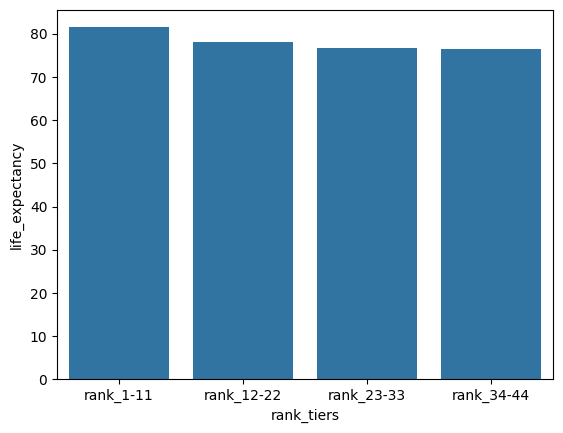

In [ ]:
sns.barplot(data=df, x=df["rank_tiers"], y=df["life_expectancy"], errorbar=None)

Based on this plot life expectancy is not a defining characteristic because there is little difference between the rank tiers

## Obesity Percentage Bar Plot

<Axes: xlabel='rank_tiers', ylabel='obesity_percent'>

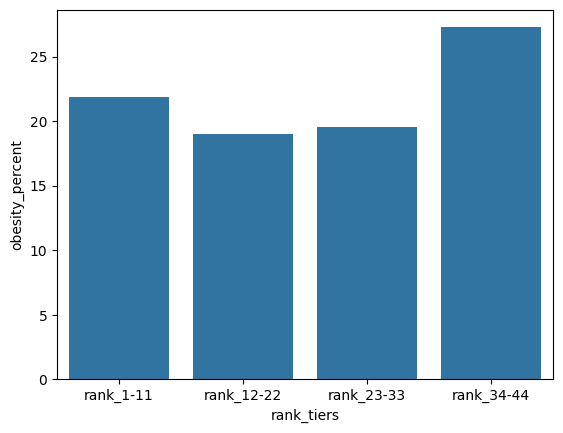

In [ ]:
sns.barplot(data=df, x=df["rank_tiers"], y=df["obesity_percent"], errorbar=None)

Based on this plot obesity percentage is a defining characteristic because the low ranking cities have much higher percentage than high ranking cities

## Happiness Levels Bar Plot

<Axes: xlabel='rank_tiers', ylabel='happiness_levels'>

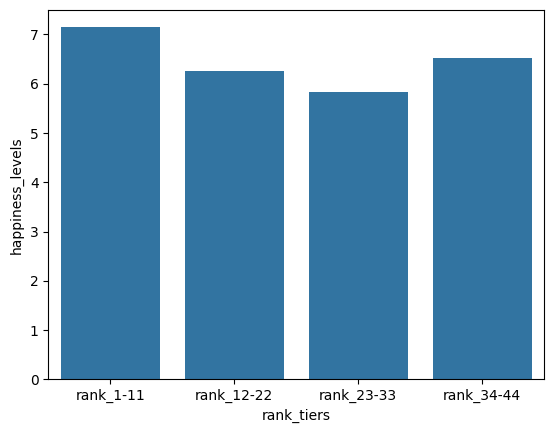

In [ ]:
sns.barplot(data=df, x=df["rank_tiers"], y=df["happiness_levels"], errorbar=None)

## Outdoor Activities Bar Plot

<Axes: xlabel='rank_tiers', ylabel='outdoor_activities'>

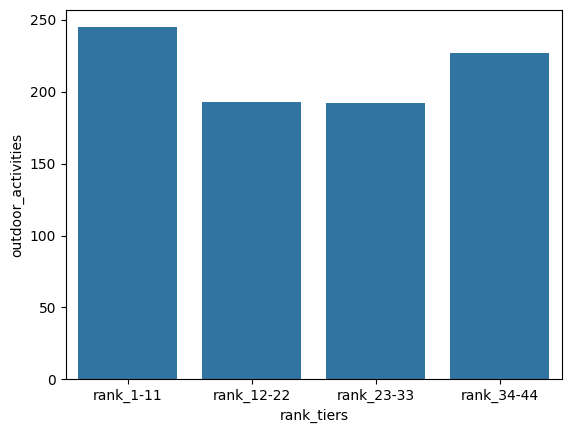

In [ ]:
sns.barplot(data=df, x=df["rank_tiers"], y=df["outdoor_activities"], errorbar=None)

## Pollution Index Bar Plot

<Axes: xlabel='rank_tiers', ylabel='pollution_index'>

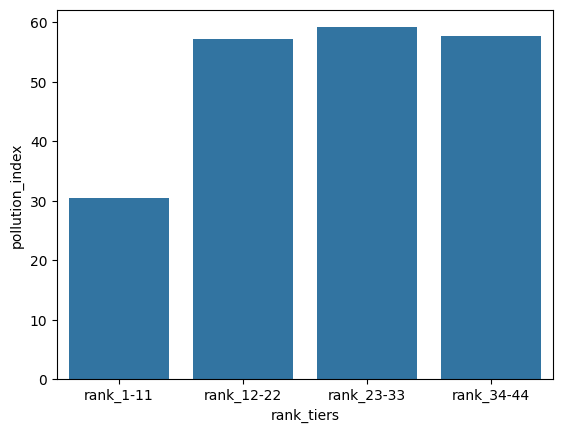

In [ ]:
sns.barplot(data=df, x=df["rank_tiers"], y=df["pollution_index"], errorbar=None)

## Average Hours Worked Bar Plot

<Axes: xlabel='rank_tiers', ylabel='avg_hours_worked'>

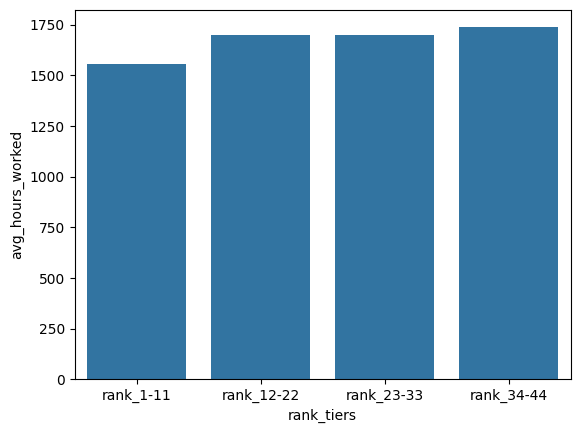

In [ ]:
sns.barplot(data=df, x=df["rank_tiers"], y=df["avg_hours_worked"], errorbar=None)

## Sunshine Hours Bar Plot

<Axes: xlabel='rank_tiers', ylabel='sunshine_hours'>

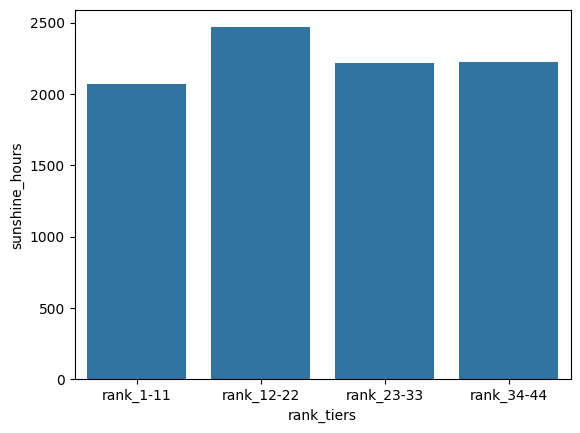

In [ ]:
sns.barplot(data=df, x=df["rank_tiers"], y=df["sunshine_hours"], errorbar=None) 

## Takeout Places Bar Plot

<Axes: xlabel='rank_tiers', ylabel='takeout_places'>

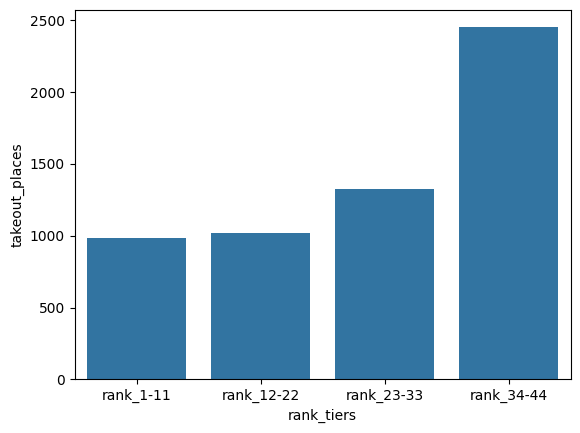

In [ ]:
sns.barplot(data=df, x=df["rank_tiers"], y=df["takeout_places"], errorbar=None)

## Bottled Water Cost Bar Plot

<Axes: xlabel='rank_tiers', ylabel='bottled_water_cost_usd'>

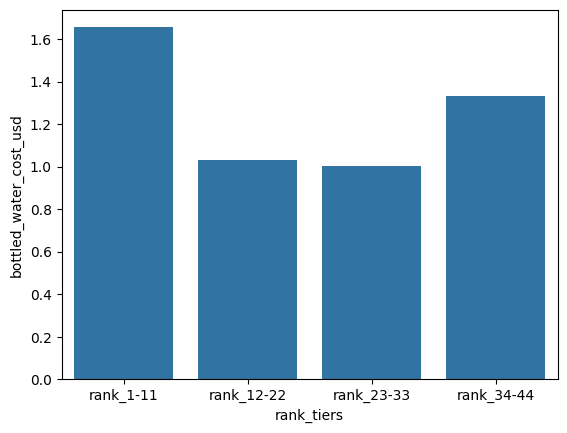

In [ ]:
sns.barplot(data=df, x=df["rank_tiers"], y=df["bottled_water_cost_usd"], errorbar=None)

## Cost of Gym Membership Bar Plot

<Axes: xlabel='rank_tiers', ylabel='gym_cost_usd'>

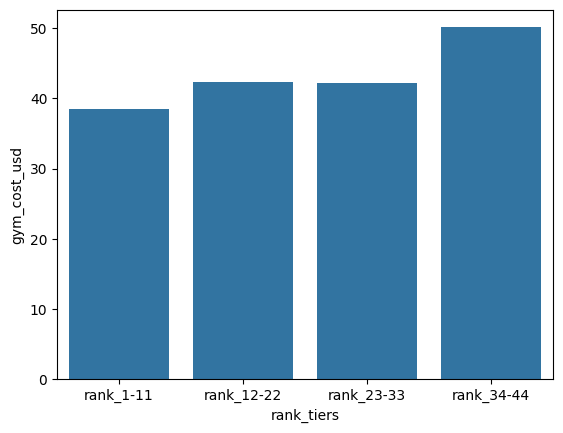

In [ ]:
sns.barplot(data=df, x=df["rank_tiers"], y=df["gym_cost_usd"], errorbar=None)

## Bar Plot Conclusions

Based on the bar plots, the characteristics that most separated high ranking cities from low ranking ones were:
* Obesity Percentage
* Pollution Index
* Takeout Places